# Set up the working directory and enviroment

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/NGN2/combined1_hNGN2")

In [0]:
! pip3 install leidenalg 
! pip3 install scanpy

In [0]:
import h5py
import numpy as np
import pandas as pd
import scanpy as sc

In [0]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.4 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.2 leidenalg==0.8.0


# 1. First generate cluster info for each cells

It doesn't matter whether the adata is ubsetted using HVG or not, because the attribute of leiden cluster belongs to cells, which is not subsetted.



The adata object is combined1_hNGN2_18April2020_after_cluster.h5d.

The cluster info is saved in cluster_seq.csv


In [0]:
adata1 = sc.read_h5ad("combined1_hNGN2_18April2020_after_cluster.h5d")

In [0]:
adata1

AnnData object with n_obs × n_vars = 10342 × 2814
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [0]:
cluster_seq = adata1.obs.leiden
#cluster_seq = sc.get.obs_df(adata, keys=["leiden"])
cluster_seq.to_csv("tables/cluster_seq.csv")

# Next to extract normalized counts (without log1p, regress, and scale) for the collabrator

Starting from the beginning

In [0]:
# basic filtering
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5") 
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) 
mito_genes = adata.var_names.str.startswith('MT-')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(axis=1).A1 
adata = adata[adata.obs.n_genes < 7500, :]
adata = adata[adata.obs.percent_mito < 0.25, :]                    

Extract the df

# Explor the data details after each step of conversion or transformation

In [0]:
adata

View of AnnData object with n_obs × n_vars = 10342 × 20913
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [0]:
print("before normalization", np.max(adata.X.toarray()))

before normalization 1191.0


In [0]:
# normalize the total counts of each cell to 1e4 (i.e., library size normalization)
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [0]:
print("after normalization", np.max(adata.X.toarray()))

after normalization 2060.3015


In [0]:
# do log1p transformation
sc.pp.log1p(adata)

In [0]:
print("after log1p, the max", np.max(adata.X.toarray()))
print("after log1p, the min", np.min(adata.X.toarray()))

after log1p, the max 7.631093
after log1p, the min 0.0


In [0]:
# extrac HVG
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [0]:
print("after HVG, the max", np.max(adata.X.toarray()))
print("after HVG, the min", np.min(adata.X.toarray()))

after HVG, the max 7.631093
after HVG, the min 0.0


In [0]:
# subset using HVG actually can get rid some high aboundant but not variabe genes
adata = adata[:, adata.var.highly_variable]

In [0]:
print("after subset, the max", np.max(adata.X.toarray()))
print("after subset, the min", np.min(adata.X.toarray()))

after subset, the max 5.5846343
after subset, the min 0.0


In [0]:
# here X is still dense matrix
adata.X.toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.613611 ,
        1.1020911],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.8158926, 0.8158926,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 1.5537679,
        1.0524385],
       [0.       , 0.       , 0.       , ..., 1.1572034, 1.1572034,
        1.1572034]], dtype=float32)

In [0]:
df = pd.DataFrame(adata.X.toarray())

In [0]:
df.to_csv("NGN2_normalized_log1p_count_hvg.csv")

In [0]:
# do regression and scaling
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:32)


In [0]:
# after regression and scaling, matrix become numpy.mdarray
adata.X

array([[-0.1020311 , -0.19910787, -0.17232439, ..., -0.6911254 ,
        -1.2315489 , -1.280314  ],
       [-0.10826704, -0.1913667 , -0.17365292, ..., -0.73530877,
         1.296886  ,  0.41318575],
       [-0.12301406, -0.1759912 , -0.16931435, ..., -0.90273064,
        -0.7050036 , -0.7123437 ],
       ...,
       [-0.12560984, -0.17880794, -0.15445553, ...,  0.17681964,
         0.47877875, -0.77813214],
       [-0.11673684, -0.18350872, -0.16867855, ..., -0.85235286,
         1.4024539 ,  0.53938925],
       [-0.12259827, -0.17635748, -0.16960827, ...,  0.8445865 ,
         0.9785806 ,  0.8576297 ]], dtype=float32)

In [0]:
# after scale, mean is centered at 0
print("after scale, the max", np.max(adata.X))
print("after scale, the min", np.min(adata.X))

after subset, the max 10.0
after subset, the min -5.3566637


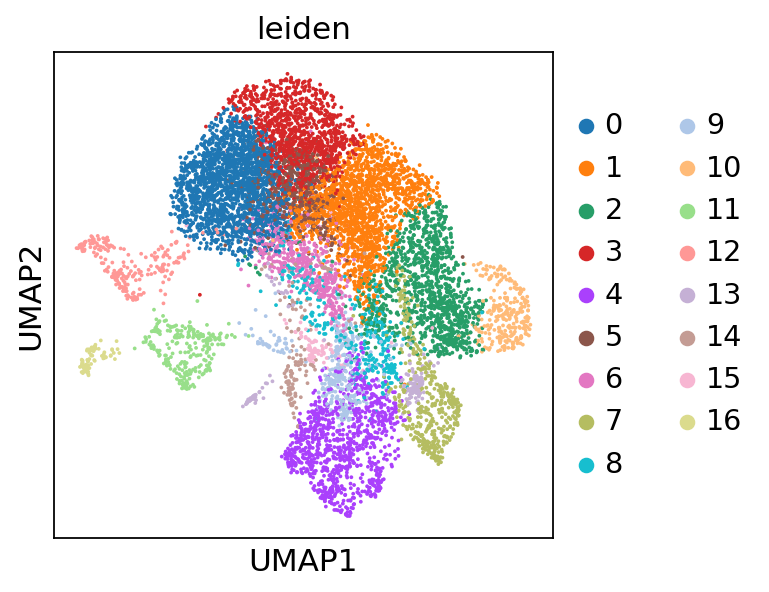

In [0]:
sc.pl.umap(adata, color=['leiden'], save='combined1_hNGN2_18April2020_.pdf')

In [0]:
adata.write_h5ad("combined1_hNGN2_18April2020_after_cluster.h5d")

Generate dataframe by read matrix, adding gene symbols, clusters

In [0]:
df = pd.DataFrame(adata.X.toarray())
df.columns = adata.var.index.values
#df.columns = adata.var_names.values
cluster_seq = pd.read_csv("cluster_seq.csv")
df["cluster"] = cluster_seq.leiden.values
# add the info of cluster for each cell, which was obtained by sending the unsubset adata for leiden
cluster_seq = pd.read_csv("tables/cluster_seq.csv")
df["cluster"] = cluster_seq.leiden.values

Groupby by cluster and aggregated by mean and std separately

In [0]:
# notice that std sometimes bigger than mean
df_mean = df.groupby("cluster").agg("mean")
df_std = df.groupby("cluster").agg("std")

Groupby by cluster and aggregated by mean and std together

In [0]:
df_all_group = df_all.groupby("cluster").agg(["mean","std"])
# transpose columns to rows
df_all_group.T.to_csv("normalized_counts_by_cluster.csv")
df_all_group_t

In [0]:
df_all_group.T.to_csv("normalized_counts_by_cluster.csv")

cluster                0         1         2   ...        14        15        16
AL627309.1 mean  0.006765  0.004274  0.005605  ...  0.015325  0.040401  0.000000
           std   0.126128  0.099584  0.085349  ...  0.131491  0.372477  0.000000
AL669831.5 mean  0.087235  0.107059  0.087666  ...  0.104180  0.161024  0.028077
           std   0.486389  0.574301  0.405442  ...  0.330427  0.655926  0.241528
FAM87B     mean  0.000000  0.001234  0.001492  ...  0.000000  0.032321  0.000000
...                   ...       ...       ...  ...       ...       ...       ...
AL354822.1 std   0.000000  0.183975  0.051121  ...  0.046478  0.000000  0.000000
AC004556.1 mean  0.049719  0.066583  0.070330  ...  0.046049  0.043403  0.000000
           std   0.374840  0.401418  0.341701  ...  0.208683  0.281687  0.000000
AC240274.1 mean  0.167723  0.165668  0.154300  ...  0.150018  0.090954  0.222471
           std   0.698341  0.670979  0.788802  ...  0.382120  0.524766  0.648512

[41826 rows x 17 columns]

## Generate diffferetial genes for each cluster

Need the object after clustering on HVG

In [0]:
adata = sc.read_h5ad("combined1_hNGN2_18April2020_after_cluster.h5d")   

In [0]:
# re-generate the rank_genes_groups
# Usually we chose n_genes=100, here extract all HVG for the collabrator
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=adata.shape[1])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:18)


In [0]:
# generate the dataframe containg 20K genes and their logfoldchange, and etc.
clusters = adata.obs.leiden.value_counts().index.to_list()
for cluster in clusters:
  sub_df = sc.get.rank_genes_groups_df(adata, group=cluster)
  sub_df.to_csv("genes_by_cluster_"+cluster+".csv")

In [0]:
df = sc.get.rank_genes_groups_df(adata, group="0")

In [0]:
df

,scores,names,logfoldchanges,pvals,pvals_adj
0,50.471680,B2M,3.057781,0.000000,0.000000
1,45.918098,HLA-A,2.407008,0.000000,0.000000
2,44.341412,MDK,1.959031,0.000000,0.000000
3,44.041897,DLL3,2.193263,0.000000,0.000000
4,43.893505,EMP2,2.686457,0.000000,0.000000
...,...,...,...,...,...
2809,0.176590,TIGD6,0.502818,0.859830,0.999857
2810,0.175996,SLC12A5-AS1,0.338898,0.860297,0.999857
2811,0.175629,AC091133.2,0.851586,0.860586,0.999857
2812,0.175381,HHAT,0.516751,0.860780,0.999857


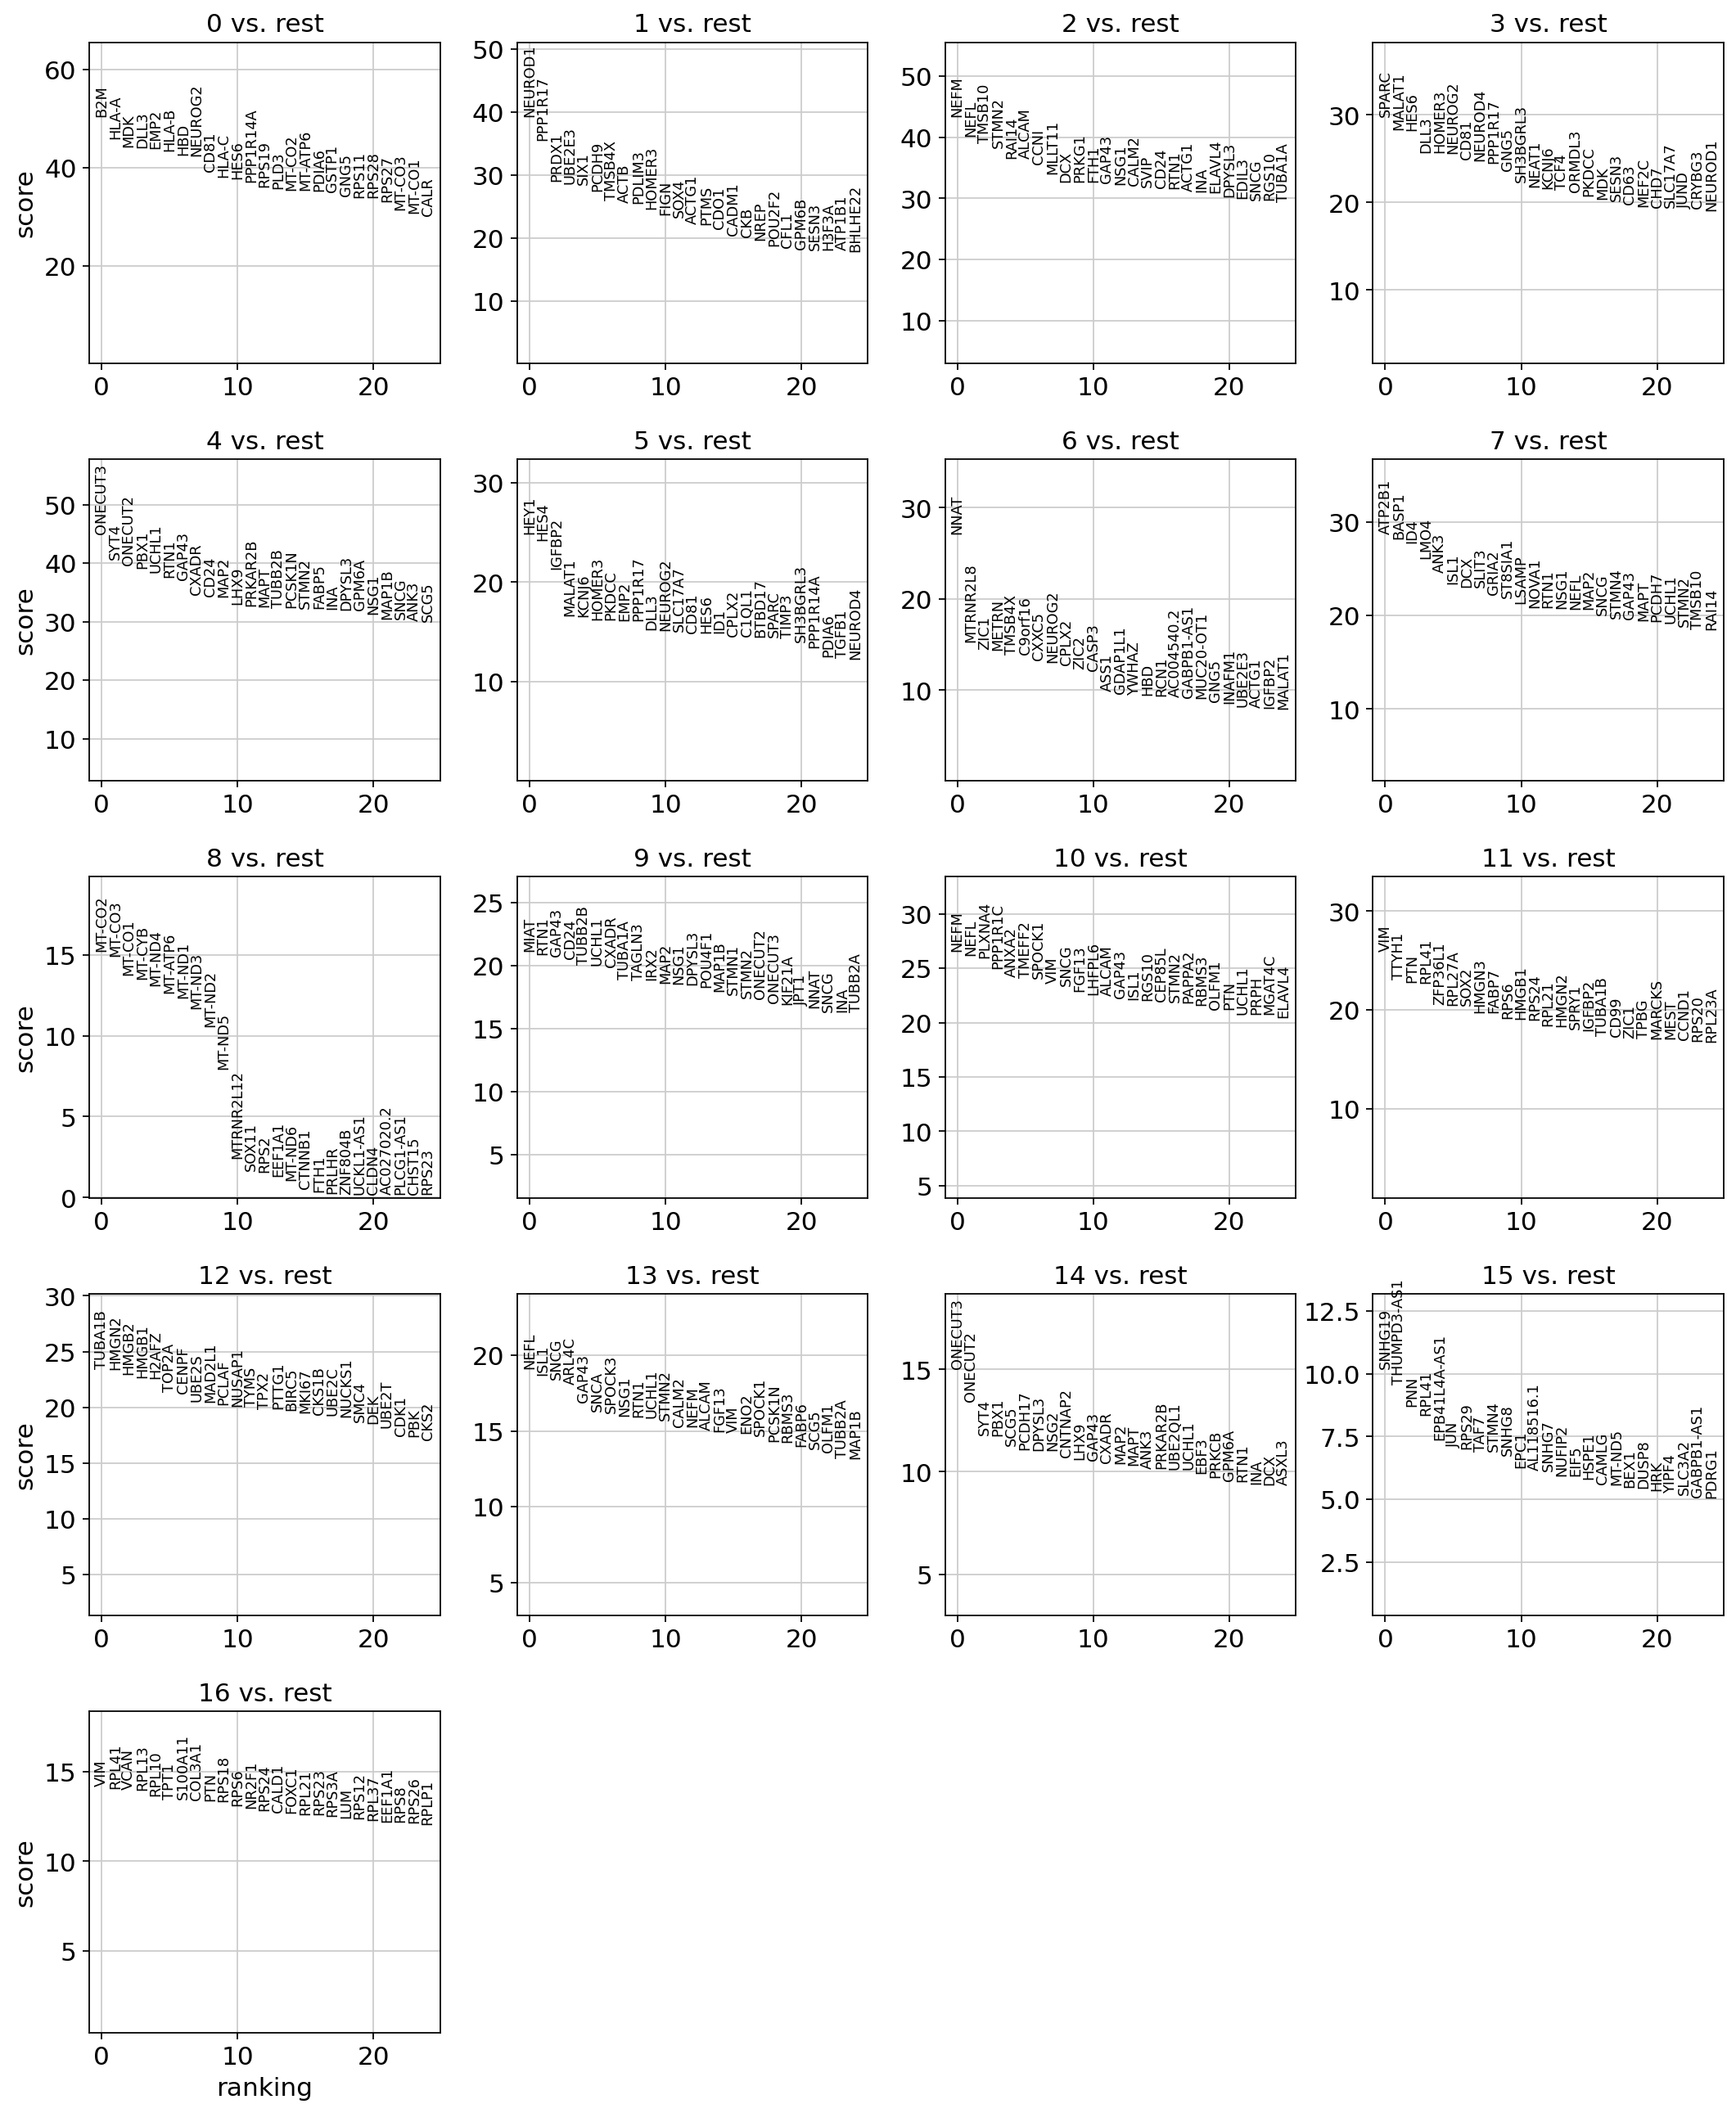

In [0]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## Manipulate multiindex

In [0]:
df_grouped = df.groupby("cluster").agg(["mean", "std"])

In [0]:
# slice multiinex  by using pd.IndexSlice
idx = pd.IndexSlice
#df= df.loc[idx[:,[3,4]],:]
df_mean= df_grouped.loc[:, idx[:,"mean"]]
# drop one level: from top to bottom: 0-1
df_mean = df_mean.droplevel(1, axis=1)

In [0]:
# std is so big
df_grouped_std
# it is large with 40k columns
df_grouped.T.to_csv("mean_N2N2_all_gene_by_clusters.csv")

,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,AL645608.5,AL645608.1,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,AL645608.8,HES4,ISG15,AL645608.2,AGRN,C1orf159,TTLL10,TNFRSF18,SDF4,B3GALT6,C1QTNF12,AL162741.1,UBE2J2,LINC01786,SCNN1D,ACAP3,PUSL1,INTS11,CPTP,TAS1R3,DVL1,MXRA8,AURKAIP1,CCNL2,MRPL20,AL391244.3,...,AL133492.1,AL592528.1,AJ011932.1,COL6A1,AP001476.1,COL6A2,FTCD,SPATC1L,LSS,AP001469.1,MCM3AP-AS1,MCM3AP,AP001469.2,AP001469.3,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,BX004987.1,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC004556.1,AC240274.1
,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,...,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std,std
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.542622,0.953262,0.011880,1.100166,0.701973,0.221405,1.004936,0.006892,0.222736,0.571064,1.082312,0.893675,0.384882,0.220885,0.980104,1.059095,1.090573,0.017714,1.064269,0.904385,0.012737,0.221166,1.170164,1.059468,0.543014,0.222239,1.081670,0.542046,0.922407,1.017740,1.098832,1.063300,0.927010,0.443300,1.076698,0.626997,1.076580,1.045094,1.075308,0.362246,...,1.052478,0.006238,0.823090,1.091248,0.222560,1.107885,1.076272,1.259680,1.033502,0.224081,0.974573,1.115935,0.220973,0.982273,0.985475,0.850086,1.043269,1.065843,0.313480,0.950377,0.880633,0.978699,0.892267,0.842974,1.138457,0.833497,0.860232,0.874959,1.062576,0.959692,1.020720,1.090242,0.938115,0.221207,1.051423,0.566116,1.310143,0.022099,1.020389,1.031254
1,0.479228,1.033170,0.247036,0.859954,0.805931,0.247478,1.046668,0.427881,0.762666,0.888108,1.014860,1.069991,0.675387,0.246916,0.760737,0.900831,0.776288,0.247214,1.056698,1.014903,0.009249,0.005444,0.976068,0.977225,0.806300,0.350051,1.023181,0.350025,0.723138,1.054109,0.901370,1.027352,1.115248,0.350467,1.077729,0.782806,1.021376,0.990538,1.004994,0.783071,...,1.213588,0.009162,0.402748,1.006973,0.020541,0.549258,0.890114,0.944546,1.003530,0.025321,1.037645,0.953610,0.349223,0.894506,0.987853,0.697462,1.000263,0.982792,0.347043,1.045085,0.722146,0.906893,0.754873,0.687630,1.043111,0.678782,0.654991,0.738964,1.020807,0.756602,0.976647,0.986590,0.707406,0.006572,1.068102,0.430000,0.905585,0.605559,1.170315,1.009934
2,0.661247,0.901840,0.295100,0.681581,0.930964,0.296743,0.723094,0.511017,0.762279,1.028548,0.886663,1.081849,1.003796,0.009391,0.583505,0.742261,0.611420,0.013290,0.938240,0.895031,0.009152,0.005138,0.800125,0.893359,0.588885,0.296021,0.896524,0.591082,0.603898,0.921837,0.973836,0.911528,1.011002,0.591010,0.915735,0.550587,0.868553,0.901695,0.886650,0.819149,...,1.080045,0.012613,1.320079,0.905244,0.018809,0.317990,0.605890,0.638427,1.032376,0.417410,0.887694,0.889272,0.012613,0.818112,1.000272,0.794796,0.869421,0.957587,0.026453,0.911929,0.898258,0.829226,0.722777,0.733952,0.800907,0.704265,0.724193,0.840184,0.835908,0.787306,0.824434,0.881671,0.784294,0.006814,0.885875,0.897381,0.789571,0.512263,1.135058,0.937858
3,0.595708,1.106992,0.011845,0.852628,0.900737,0.421422,1.219465,0.006507,0.649632,0.705762,1.010850,0.921636,0.667101,0.297068,0.956182,1.005178,1.137871,0.297482,0.979805,1.020174,0.011503,0.419823,1.018401,0.987703,0.516216,0.594713,0.998918,0.646410,1.019120,1.036572,0.972812,0.959085,0.917516,0.639286,1.060581,0.992108,0.982696,1.056936,0.959814,0.728195,...,1.141176,0.297519,0.353639,0.984085,0.017555,0.712034,1.159971,1.143570,0.977513,0.420833,1.007548,1.091801,0.013556,1.160766,0.938336,0.734565,1.065302,0.939021,0.382915,0.971758,0.961084,1.009565,1.176283,1.177039,1.002803,1.165099,1.244557,1.035626,0.972233,1.108642,1.012648,0.901115,1.180395,0.006047,1.157211,0.533459,1.023050,0.421350,0.860228,0.943245
4,0.506948,0.982906,0.31

# Export a list of marker genes

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

top_marker_genes.to_csv('scanpy_out/top_markers_combined1_hNGN2.csv')

In [0]:
top_marker_genes.head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p
0,B2M,0.0,NEUROD1,0.000000e+00,NEFM,0.000000e+00,SPARC,1.155062e-195,ONECUT3,0.0,HEY1,1.102096e-136,NNAT,2.079472e-162,ATP2B1,9.873014e-182,MT-CO2,2.049262e-52,MIAT,3.176848e-99,NEFM,7.705019e-156,VIM,9.105686e-149,TUBA1B,3.233443e-122,NEFL,1.223102e-81,ONECUT3,2.895115e-51,SNHG19,1.659336e-24,VIM,7.078307e-46
1,HLA-A,0.0,PPP1R17,1.996984e-277,NEFL,0.000000e+00,MALAT1,2.203855e-176,SYT4,0.0,HES4,4.744222e-129,MTRNR2L8,3.429132e-53,BASP1,1.789532e-175,MT-CO3,3.249441e-50,RTN1,6.971203e-97,NEFL,3.425596e-151,TTYH1,2.330934e-118,HMGN2,1.971871e-121,ISL1,9.707455e-78,ONECUT2,3.000772e-41,THUMPD3-AS1,8.480152e-22,RPL41,4.706204e-45
2,MDK,0.0,PRDX1,6.335377e-185,TMSB10,0.000000e+00,HES6,1.168425e-175,ONECUT2,0.0,IGFBP2,4.085797e-101,ZIC1,1.158058e-47,ID4,3.282880e-169,MT-CO1,4.367266e-43,GAP43,2.095056e-95,PLXNA4,5.026066e-149,PTN,4.101293e-115,HMGB2,6.629459e-117,SNCG,1.067199e-75,SYT4,4.060879e-32,PNN,2.903318e-18,VCAN,9.269207e-45
3,DLL3,0.0,UBE2E3,6.915241e-181,STMN2,0.000000e+00,DLL3,4.919633e-146,PBX1,0.0,MALAT1,6.580836e-62,METRN,2.376905e-47,LMO4,5.014336e-150,MT-CYB,1.986600e-41,CD24,6.865104e-94,PPP1R1C,3.171733e-138,RPL41,2.604090e-114,HMGB1,1.403965e-113,ARL4C,4.516790e-73,PBX1,6.597661e-32,RPL41,7.427137e-17,RPL13,2.984641e-44
4,EMP2,0.0,SIX1,7.955425e-179,RAI14,5.897877e-293,HOMER3,2.759414e-145,UCHL1,0.0,KCNJ6,9.556269e-62,TMSB4X,4.248613e-44,ANK3,1.572837e-133,MT-ND4,3.923301e-39,TUBB2B,1.099417e-89,ANXA2,6.057025e-130,ZFP36L1,6.637362e-94,H2AFZ,2.529223e-113,GAP43,5.722046e-64,SCG5,1.248950e-29,EPB41L4A-AS1,1.632184e-13,RPL10,1.612779e-42


In [0]:
# get a list of top20 marker genes of cluster 1
marker_genes_cluster1 = top_marker_genes["1_n"][:20].values